In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [54]:
data = '../data/MIT/'
original = img.imread(data + 'apple/original.png')
reflectance = img.imread(data + 'apple/reflectance.png')
shading = img.imread(data + 'apple/shading.png')
shading = np.stack([shading,shading,shading], axis=2)

In [26]:
data = '../data/Sintel/'
cleans = data + 'clean/'
albedos = data + 'albedo/'
frame = 'alley_1/frame_0001.png'

original = (np.clip(img.imread('../data/frame_0002.png', format='RGB'), 0, 254) + 1) / 255
reflectance = (np.clip(img.imread('../data/frame_0001.png', format='RGB'), 0, 254) + 1) / 255



shading = np.clip(original / reflectance, 0, 1)
# shading = (original/2) / reflectance

In [27]:
# print(shading)

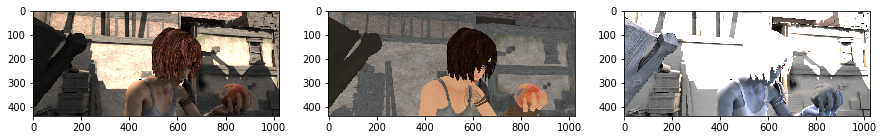

In [28]:
fig = plt.figure(figsize=(15, 15))
a=fig.add_subplot(1,3,1)
imgplot = plt.imshow(original)

a=fig.add_subplot(1,3,2)
imgplot = plt.imshow(reflectance)

a=fig.add_subplot(1,3,3)
imgplot = plt.imshow(shading)

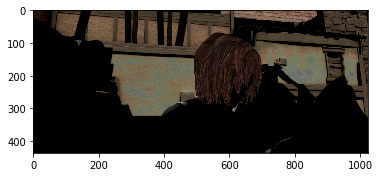

In [33]:
original2 = reflectance * shading
plt.imshow(original - original2)

In [59]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras import backend as K

Using TensorFlow backend.


In [3]:
FLAG = '/cvlabdata1/cvlab/datasets_aoun/flag_2/'
IMAGES = 'images/'
ALBEDOS = 'albedos/'
SHADINGS = 'shadings/'
SYNTHS = 'synths/'

TYPE = 'b31_tl_tr-cotton/'

In [4]:
img_width, img_height = 224, 224

train_data_dir = FLAG + SYNTHS + TYPE
validation_data_dir = FLAG + SHADINGS + TYPE
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

In [5]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
    
    
print(input_shape)

(224, 224, 3)


In [6]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(64, (3, 3)))

#how to merge these 3?
model.add(UpSampling2D(size=(2, 2)))
model.add(UpSampling2D(size=(2, 2)))
model.add(UpSampling2D(size=(2, 2)))
### 8,8

model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# add last layer width 1

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [7]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [8]:
train_generator = datagen.flow_from_directory(
        FLAG + IMAGES + TYPE,  # this is the target directory
#         '/home/aoun/dl/',
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode=None)

Found 0 images belonging to 0 classes.


In [11]:
def build_model(nb_filters=32, nb_pool=2, nb_conv=3):
    C_1 = 64
    C_2 = 32
    C_3 = 16
    c = Convolution2D(C_1, nb_conv, nb_conv, border_mode='same', input_shape=input_shape)
    mp = MaxPooling2D(pool_size=(nb_pool, nb_pool))
    c2 = Convolution2D(C_2, nb_conv, nb_conv, border_mode='same', input_shape=input_shape)
    mp2 = MaxPooling2D(pool_size=(nb_pool, nb_pool))
    d = Dense(100)
    encoder = get_encoder(c, c2, d, mp, mp2)
    decoder = get_decoder(C_1, C_2, C_3, c, c2, d, mp, mp2, nb_pool)

    graph = Graph()
    graph.add_input(name='input', input_shape=input_shape)
    graph.add_node(encoder, name='encoder', input='input')
    graph.add_node(decoder, name='decoder', input='encoder')
    graph.add_output(name='autoencoder_feedback', input='decoder')
    graph.compile('rmsprop', {'autoencoder_feedback': 'mean_squared_error'})

    return graph



def get_decoder(C_1, C_2, C_3, c, c2, d, mp, mp2, nb_pool):
    decoder = models.Sequential()

    decoder.add(DependentDense(d.input_shape[1], d, input_shape=(d.output_shape[1],)))
    decoder.add(Activation('tanh'))
    decoder.add(Reshape((C_2, 8, 8)))
    # ====================================================
    # decoder.add(DePool2D(mp3, size=(nb_pool, nb_pool)))
    # decoder.add(Deconvolution2D(c3, nb_out_channels=C_2, border_mode='same'))
    # decoder.add(Activation('tanh'))
    # ====================================================
    decoder.add(UpSampling2D(mp2, size=(nb_pool, nb_pool)))
    decoder.add(Convolution2D(c2, nb_out_channels=C_1, border_mode='same'))
    decoder.add(Activation('tanh'))
    # ====================================================
    # Changed from Deconvolution2D to Convolution2D (here and up)
    decoder.add(UpSampling2D(mp, size=(nb_pool, nb_pool)))
    decoder.add(Convolution2D(c, nb_out_channels=3, border_mode='same'))
    decoder.add(Activation('tanh'))
    # ====================================================
    return decoder


def get_encoder(c, c2, d, mp, mp2):
    encoder = models.Sequential()
    # ====================================================
    encoder.add(c)
    encoder.add(Activation('tanh'))
    encoder.add(mp)
    # ====================================================
    encoder.add(Dropout(0.25))
    # ====================================================
    encoder.add(c2)
    encoder.add(Activation('tanh'))
    encoder.add(mp2)
    # ====================================================
    # model.add(c3)
    # model.add(Activation('tanh'))
    # model.add(mp3)
    # ====================================================
    encoder.add(Dropout(0.25))
    # ====================================================
    encoder.add(Flatten())
    encoder.add(d)
    encoder.add(Activation('tanh'))
    return encoder